Often, we have data which has a group structure. For example, in the dataset we use in this post, radon measurements were taken in ~900 houses in 85 counties. It's unreasonable to expect that radon levels do not vary by state as well as house, and so we will integrate this into our analysis. 

Typically, in linear regression we assume that each data point is independent and regresses with a constant slope amongst each other:

$$ y = X^T\beta + \varepsilon $$

where

$$ \varepsilon \sim N\left(0, I\right) $$ 

and \\(X\\) are known as fixed effects coefficients. To define a mixed model, we include a term \\(Z\eta\\), which corresponds to *random* effects. The model is now:

$$ y = X^T\beta + Z^T\eta + \varepsilon $$

where

$$ \varepsilon \sim N\left(0, \sigma\right) $$ 

and 

$$ \eta \sim N\left(0, \sigma^2I\right) $$

We wish to infer \\(\beta, \eta, \sigma\\). Given the random effects have mean 0, the term \\(X^T\beta\\) captures the data's mean amd the term \\(Z^T\eta\\) captures variations in the data.

In [76]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')

import pystan
import statsmodels.formula.api as smf
from patsy import dmatrices

# Import radon data
radon = pd.read_csv('radon.csv')
radon.columns = radon.columns.map(str.strip)
radon_mn = radon.assign(fips=radon.stfips*1000 + radon.cntyfips)[radon.state=='MN']

In [64]:
radon_mn.county = radon_mn.county.str.strip()
n_county = radon_mn.county.unique()

county_lookup = dict(zip(mn_counties, range(len(mn_counties))))
county = radon_mn['county_code'] = radon_mn.county.replace(county_lookup).values
radon = radon_mn.activity
log_radon = radon_mn['log_radon']
floor_measure = radon_mn.floor.values

u = np.log(radon_mn.Uppm)

In [46]:
radon_mn['fips'] = radon_mn.stfips*1000 + radon_mn.cntyfips

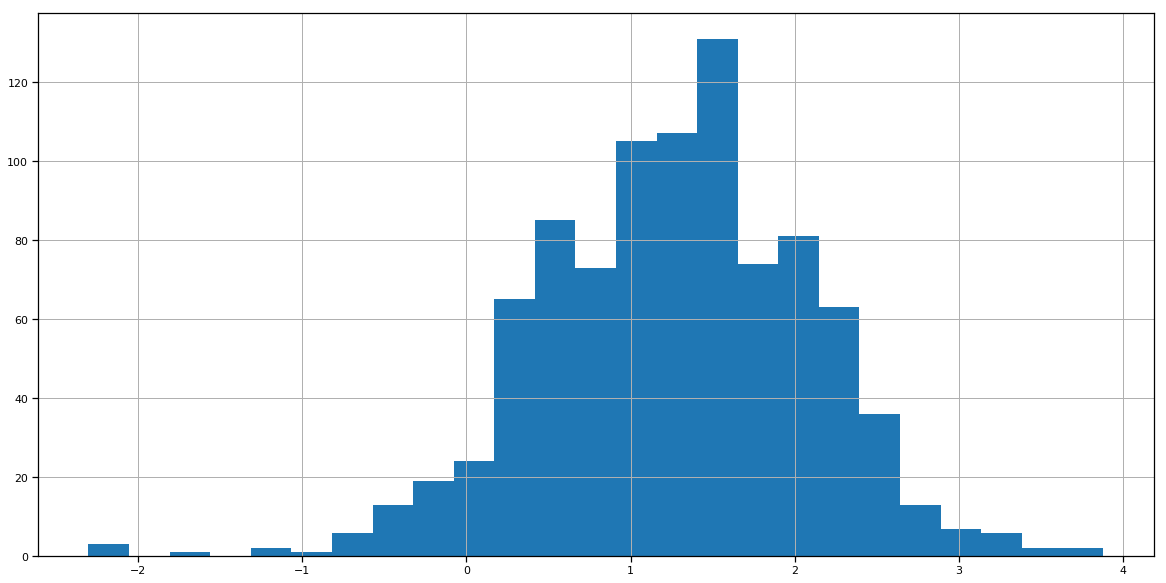

In [47]:
radon_mn.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25, figsize=(20, 10))

The simplest qway to fit a mixed model is to use StatsModels: which is what we'll do!

In [48]:
data = radon_mn[['county', 'log_radon', 'floor']]

In [49]:
formula = "log_radon ~ floor + county"

In [50]:
md  = smf.mixedlm(formula, data, groups=data["county"])
mdf = md.fit()

/Users/thomas.kealy/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [51]:
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      log_radon
No. Observations:      919          Method:                  REML     
No. Groups:            85           Scale:                   0.5279   
Min. group size:       1            Likelihood:              -994.6192
Max. group size:       116          Converged:               Yes      
Mean group size:       10.8                                           
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.887    0.810  1.095 0.274 -0.701  2.475
county[T.ANOKA]              0.043    1.088  0.040 0.968 -2.090  2.177
county[T.BECKER]             0.662    1.167  0.568 0.570 -1.625  2.949
county[T.BELTRAMI]           0.700    1.123  0.623 0.533 -1.501  2.901
county[T.BENTON]       

/Users/thomas.kealy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


In [52]:
fe_params = pd.DataFrame(mdf.fe_params, columns=['LMM'])
random_effects = pd.DataFrame(mdf.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'Group': 'LMM'})

#%% Generate Design Matrix for later use
Y, X   = dmatrices(formula, data=data, return_type='matrix')
Terms  = X.design_info.column_names
_, Z   = dmatrices("log_radon ~ county", data=data, return_type='matrix')
X      = np.asarray(X) # fixed effect
Z      = np.asarray(Z) # mixed effect
Y      = np.asarray(Y).flatten()
nfixed = np.shape(X)
nrandm = np.shape(Z)

The MSE of LMM is 0.4784635589205236


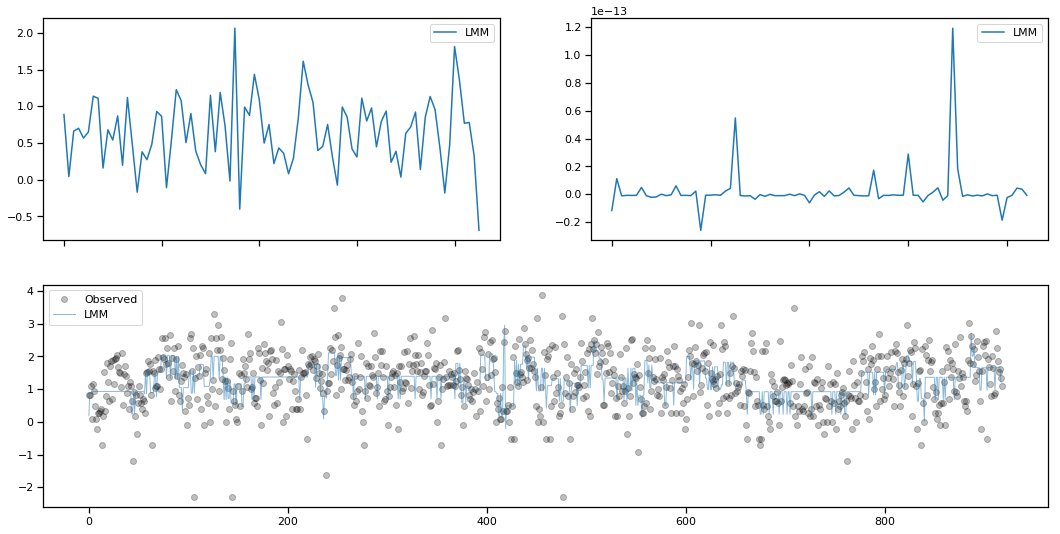

In [53]:
#%% ploting function 
def plotfitted(fe_params=fe_params,random_effects=random_effects,X=X,Z=Z,Y=Y):
    plt.figure(figsize=(18,9))
    ax1 = plt.subplot2grid((2,2), (0, 0))
    ax2 = plt.subplot2grid((2,2), (0, 1))
    ax3 = plt.subplot2grid((2,2), (1, 0), colspan=2)
    
    fe_params.plot(ax=ax1)
    random_effects.plot(ax=ax2)
    
    ax3.plot(Y.flatten(), 'o', color='k', label='Observed', alpha=.25)
    for iname in fe_params.columns.get_values():
        fitted = np.dot(X, fe_params[iname]) + np.dot(Z, random_effects[iname]).flatten()
        print("The MSE of "+ iname + " is " + str(np.mean(np.square(Y.flatten()-fitted))))
        ax3.plot(fitted, lw=1, label=iname, alpha=.5)
    ax3.legend(loc=0)
    #plt.ylim([0,5])
    plt.show()

plotfitted(fe_params=fe_params, random_effects=random_effects, X=X, Z=Z, Y=Y)

In [67]:
xbar = radon_mn.groupby('county')['floor'].mean().rename(county_lookup).values
x_mean = xbar[county]

In [70]:
stan_code = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] u;
  vector[N] x;
  vector[N] x_mean;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[3] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a[county[i]] + u[i]*b[1] + x[i]*b[2] + x_mean[i]*b[3];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
"""

In [71]:
stan_datadict = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': county+1, # Stan counts starting at 1
                          'u': u,
                          'x_mean': x_mean,
                          'x': floor_measure,
                          'y': log_radon}

stan_datadict['prior_only'] = 0

sm = pystan.StanModel(model_code=stan_code)
fit = sm.sampling(data=stan_datadict, iter=1000)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b7928e9396770558600f70afccda0012 NOW.
/Users/thomas.kealy/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [73]:
fit['b'].mean(0)

array([ 0.68677081, -0.68513895,  0.3876573 ])

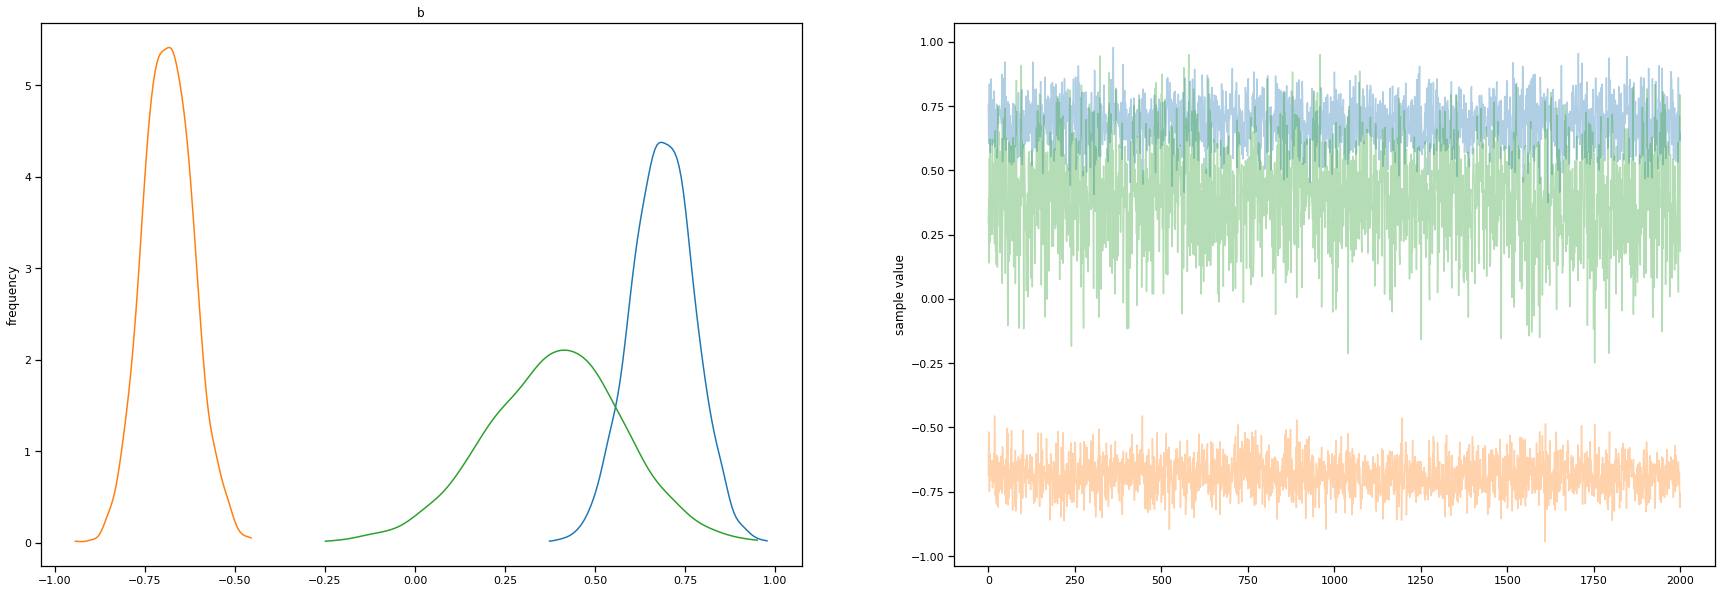

In [77]:
with mpl.rc_context():
    mpl.rc('figure', figsize=(30, 10))
    fit.plot('b')